# Import

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

# Data

In [ ]:
# Data preprocessing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
image_shape = x_train.shape[1:] if len(x_train.shape)==4 else x_train.shape[1:] +(1,) # Add one channel if there is only 3 to have shape(N_img,pix,pix,n_channel)
x_train = np.reshape(x_train, (-1,)+image_shape).astype('float32')
x_test = np.reshape(x_test, (-1,)+image_shape).astype('float32')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Training parameters
batch_size = 128
epochs = 10
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Non-Adversarial Model

In [ ]:
# Model trained without adversity
# named model1

input = tf.keras.Input(shape=image_shape)

x = tf.keras.layers.Conv2D(32,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(input)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(64,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(64,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dense(64,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

output = tf.keras.layers.Dense(10,activation = 'softmax')(x)

model1 = tf.keras.Model(inputs=input, outputs=output)

model1.summary()

model1.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics='accuracy')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 64)        0         
                                                             

In [ ]:
# Fit the model
history = model1.fit(x_train,y_train,epochs=20,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/20
391/391 [==============================] - 10s 19ms/step - loss: 1.6631 - accuracy: 0.4025 - val_loss: 1.4007 - val_accuracy: 0.5020
Epoch 2/20
391/391 [==============================] - 6s 16ms/step - loss: 1.2603 - accuracy: 0.5562 - val_loss: 1.1580 - val_accuracy: 0.6004
Epoch 3/20
391/391 [==============================] - 6s 16ms/step - loss: 1.0691 - accuracy: 0.6368 - val_loss: 1.0350 - val_accuracy: 0.6446
Epoch 4/20
391/391 [==============================] - 6s 16ms/step - loss: 0.9614 - accuracy: 0.6749 - val_loss: 0.9855 - val_accuracy: 0.6714
Epoch 5/20
391/391 [==============================] - 6s 15ms/step - loss: 0.8765 - accuracy: 0.7076 - val_loss: 0.9471 - val_accuracy: 0.6826
Epoch 6/20
391/391 [==============================] - 6s 15ms/step - loss: 0.8173 - accuracy: 0.7314 - val_loss: 0.8750 - val_accuracy: 0.7173
Epoch 7/20
391/391 [==============================] - 6s 15ms/step - loss: 0.7641 - accuracy: 0.7521 - val_loss: 0.8670 - val_accuracy: 0.716

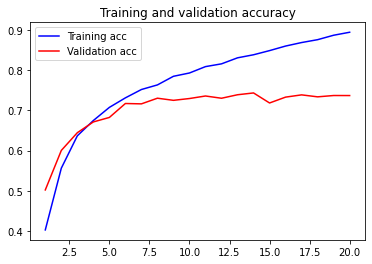

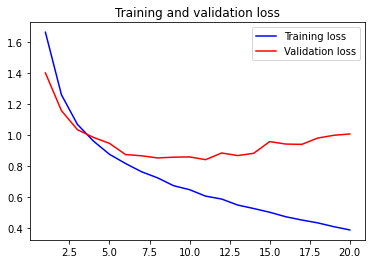

In [ ]:
# Plot loss
plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b-', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/DS#3/accuracy',dpi=300)

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/DS#3/loss',dpi=300)

Text(0.5, 1.0, 'Original : horse - Prediction : deer - Confidence : 65.42%')

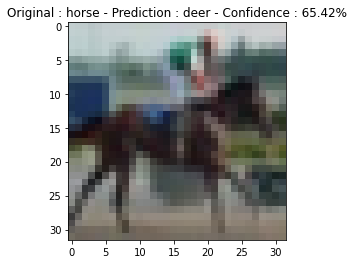

In [ ]:
# Test the network on a random image
n = np.random.randint(len(x_test)) # Image index to be tested
label = classes[np.argmax(y_test[n])]

x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model1.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]

plt.imshow(x_test[n])
plt.title('Original : {} - Prediction : {} - Confidence : {:.2f}%'.format(label, label_pred,confidence*100))

# FGSM

In [ ]:
# FGSM attack

# Input : model : model to be attacked
#         input_image : input image to be modified
#         input_label : label of the image
#         epsilon : max variation of pixel

# Output : the modified image

def FGSM_adversarial(model, input_image, input_label, epsilon):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  # Return FGSM formula
  return input_image + epsilon * signed_grad

Text(0.5, 0.98, 'True label : frog')

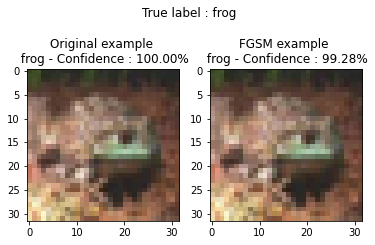

In [ ]:
# Attack parameters
epsilon = 2/255


fig, (ax1, ax2) = plt.subplots(1, 2)

# True image
n = np.random.randint(len(x_test)) # Image index to be attacked

label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model1.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]


ax1.imshow(x_test[n])
ax1.set_title('Original example \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))




# Create adverserial example


x_pred_adversarial = FGSM_adversarial(model1,tf.constant(x_pred), np.reshape(y_test[n],(-1,10)), epsilon)

y_pred_adversarial = model1.predict(x_pred_adversarial)
confidence_adversarial = np.max(y_pred_adversarial)
label_pred_adversarial = classes[np.argmax(y_pred_adversarial)]

x_pred_adversarial = np.reshape(x_pred_adversarial,(image_shape))
ax2.imshow(x_pred_adversarial)
ax2.set_title('FGSM example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial,confidence_adversarial*100))
fig.suptitle('True label : '+label)

# PGD

In [ ]:
# PGD attack

# Input : model : model to be attacked
#         input_image : input image to be modified
#         input_label : label of the image
#         epsilon : max variation of pixel
#         alpha : step size in PGD
#         nb_iter : number of PGD iteration
#         verbose : if True, print the loss at each step (to be sure the loss increases)

# Output : the modified image

def PGD_adversarial(model,input_image, input_label, epsilon, alpha, nb_iter, verbose = False):
  # Start with a random perturbation :
  input_image += (np.random.rand(1,32,32,3)*2-1)*epsilon
  tf_image = tf.constant(input_image)
  for i in range(nb_iter):
    with tf.GradientTape() as tape:
      tape.watch(tf_image)
      prediction = model(tf_image)
      loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)
      if verbose:
        print('Loss : '+str(loss))
    gradient = tape.gradient(loss, tf_image)
    signed_grad = tf.sign(gradient)
    tf_image = tf_image + alpha * signed_grad
    tf_image = tf.clip_by_value(tf_image, input_image-epsilon, input_image+epsilon)
  return tf_image

Text(0.5, 0.98, 'True label : ship')

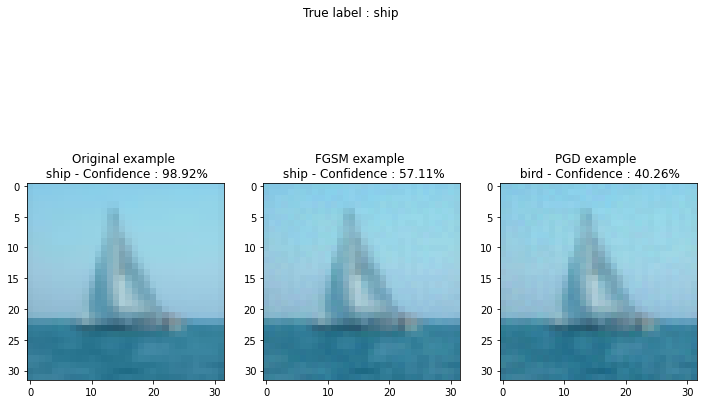

In [ ]:
# Attack parameters
epsilon = 2/255
alpha = 0.01
nb_iter = 40



plt.rcParams['figure.figsize'] = [12, 8]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# True image
n = np.random.randint(len(x_test)) # Image index to be attacked

label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model1.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]


ax1.imshow(x_test[n])
ax1.set_title('Original example \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))




# Create FGSM adverserial example


x_pred_adversarial_FGSM = FGSM_adversarial(model1, tf.constant(x_pred), np.reshape(y_test[n],(-1,10)), epsilon)

y_pred_adversarial_FGSM = model1.predict(x_pred_adversarial_FGSM)
confidence_adversarial_FGSM = np.max(y_pred_adversarial_FGSM)
label_pred_adversarial_FGSM = classes[np.argmax(y_pred_adversarial_FGSM)]

x_pred_adversarial_FGSM = np.reshape(x_pred_adversarial_FGSM,(image_shape))
ax2.imshow(x_pred_adversarial_FGSM)
ax2.set_title('FGSM example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))



# Create PGD adverserial example


x_pred_adversarial_PGD = PGD_adversarial(model1,x_pred, np.reshape(y_test[n],(-1,10)), epsilon, alpha, nb_iter)

y_pred_adversarial_PGD = model1.predict(x_pred_adversarial_PGD)
confidence_adversarial_PGD = np.max(y_pred_adversarial_PGD)
label_pred_adversarial_PGD = classes[np.argmax(y_pred_adversarial_PGD)]

x_pred_adversarial_PGD = np.reshape(x_pred_adversarial_PGD,(image_shape))
ax3.imshow(x_pred_adversarial_PGD)
ax3.set_title('PGD example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_PGD,confidence_adversarial_PGD*100))
fig.suptitle('True label : '+label)

# MagNet Autoencoder


In [ ]:
# Detector and Reformer model for CIFAR-10

input = tf.keras.Input(shape=image_shape)
x = tf.keras.layers.Conv2D(3,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(input)
x = tf.keras.layers.Activation("sigmoid")(x)
x = tf.keras.layers.Conv2D(3,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation("sigmoid")(x)
x = tf.keras.layers.Conv2D(image_shape[-1],3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation("sigmoid")(x)

model_detector = tf.keras.Model(inputs=input, outputs=x)
model_reformer = tf.keras.Model(inputs=input, outputs=x)

model_detector.summary()

model_detector.compile(optimizer='adam',loss = 'mean_squared_error', metrics='accuracy')
model_reformer.compile(optimizer='adam',loss = 'mae', metrics='accuracy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 3)         84        
                                                                 
 activation_3 (Activation)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 3)         84        
                                                                 
 activation_4 (Activation)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 3)         84        
                                                                 
 activation_5 (Activation)   (None, 32, 32, 3)         0   

In [ ]:
# We want to add different noise vectors for each epoch
num_epochs = 10
NOISE = 0     # Set to 0 for a regular (non-denoising...) autoencoder
#for i in range(num_epochs):
    #noise = np.random.normal(0, NOISE, x_train.shape)
    #model_auto.fit(x_train, x_train, epochs=1, batch_size=128)

model_detector.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

model_reformer.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
196/196 [==============================] - 5s 19ms/step - loss: 0.0532 - accuracy: 0.3811 - val_loss: 0.0284 - val_accuracy: 0.3765
Epoch 2/10
196/196 [==============================] - 3s 16ms/step - loss: 0.0187 - accuracy: 0.3933 - val_loss: 0.0153 - val_accuracy: 0.4051
Epoch 3/10
196/196 [==============================] - 3s 17ms/step - loss: 0.0144 - accuracy: 0.4176 - val_loss: 0.0138 - val_accuracy: 0.4263
Epoch 4/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0134 - accuracy: 0.4303 - val_loss: 0.0131 - val_accuracy: 0.4351
Epoch 5/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0129 - accuracy: 0.4359 - val_loss: 0.0127 - val_accuracy: 0.4357
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0125 - accuracy: 0.4408 - val_loss: 0.0123 - val_accuracy: 0.4400
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0121 - accuracy: 0.4436 - val_loss: 0.0119 - val_accuracy: 0.4456

In [ ]:
# The next three methods to visualize input/output of our model side-by-side
def hstackimgs(min, max, images):
    return np.hstack(images[i] for i in range(min, max))

def sqstackimgs(length, height, images):
    return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))

def sbscompare(images1, images2, length, height):
    A = sqstackimgs(length, height, images1)
    B = sqstackimgs(length, height, images2)
    C = np.ones((A.shape[0], 32, 3))
    return np.hstack((A, C, B))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


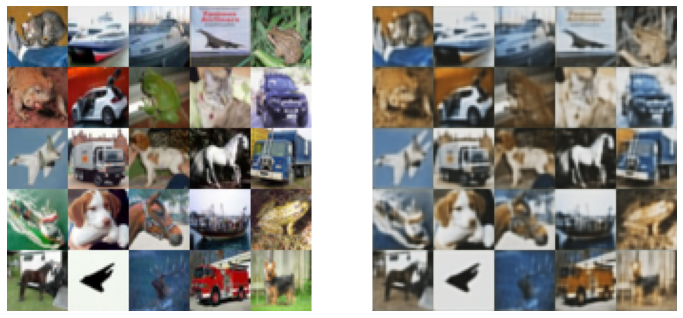

In [ ]:
x_test = x_test
#noise = np.random.normal(0, NOISE, x_test.shape)
pred_imgs = model_detector.predict(x_test)

plt.imshow(sbscompare(x_test, pred_imgs, 5, 5))
plt.axis('off')
plt.rcParams["figure.figsize"] = [60,60]
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


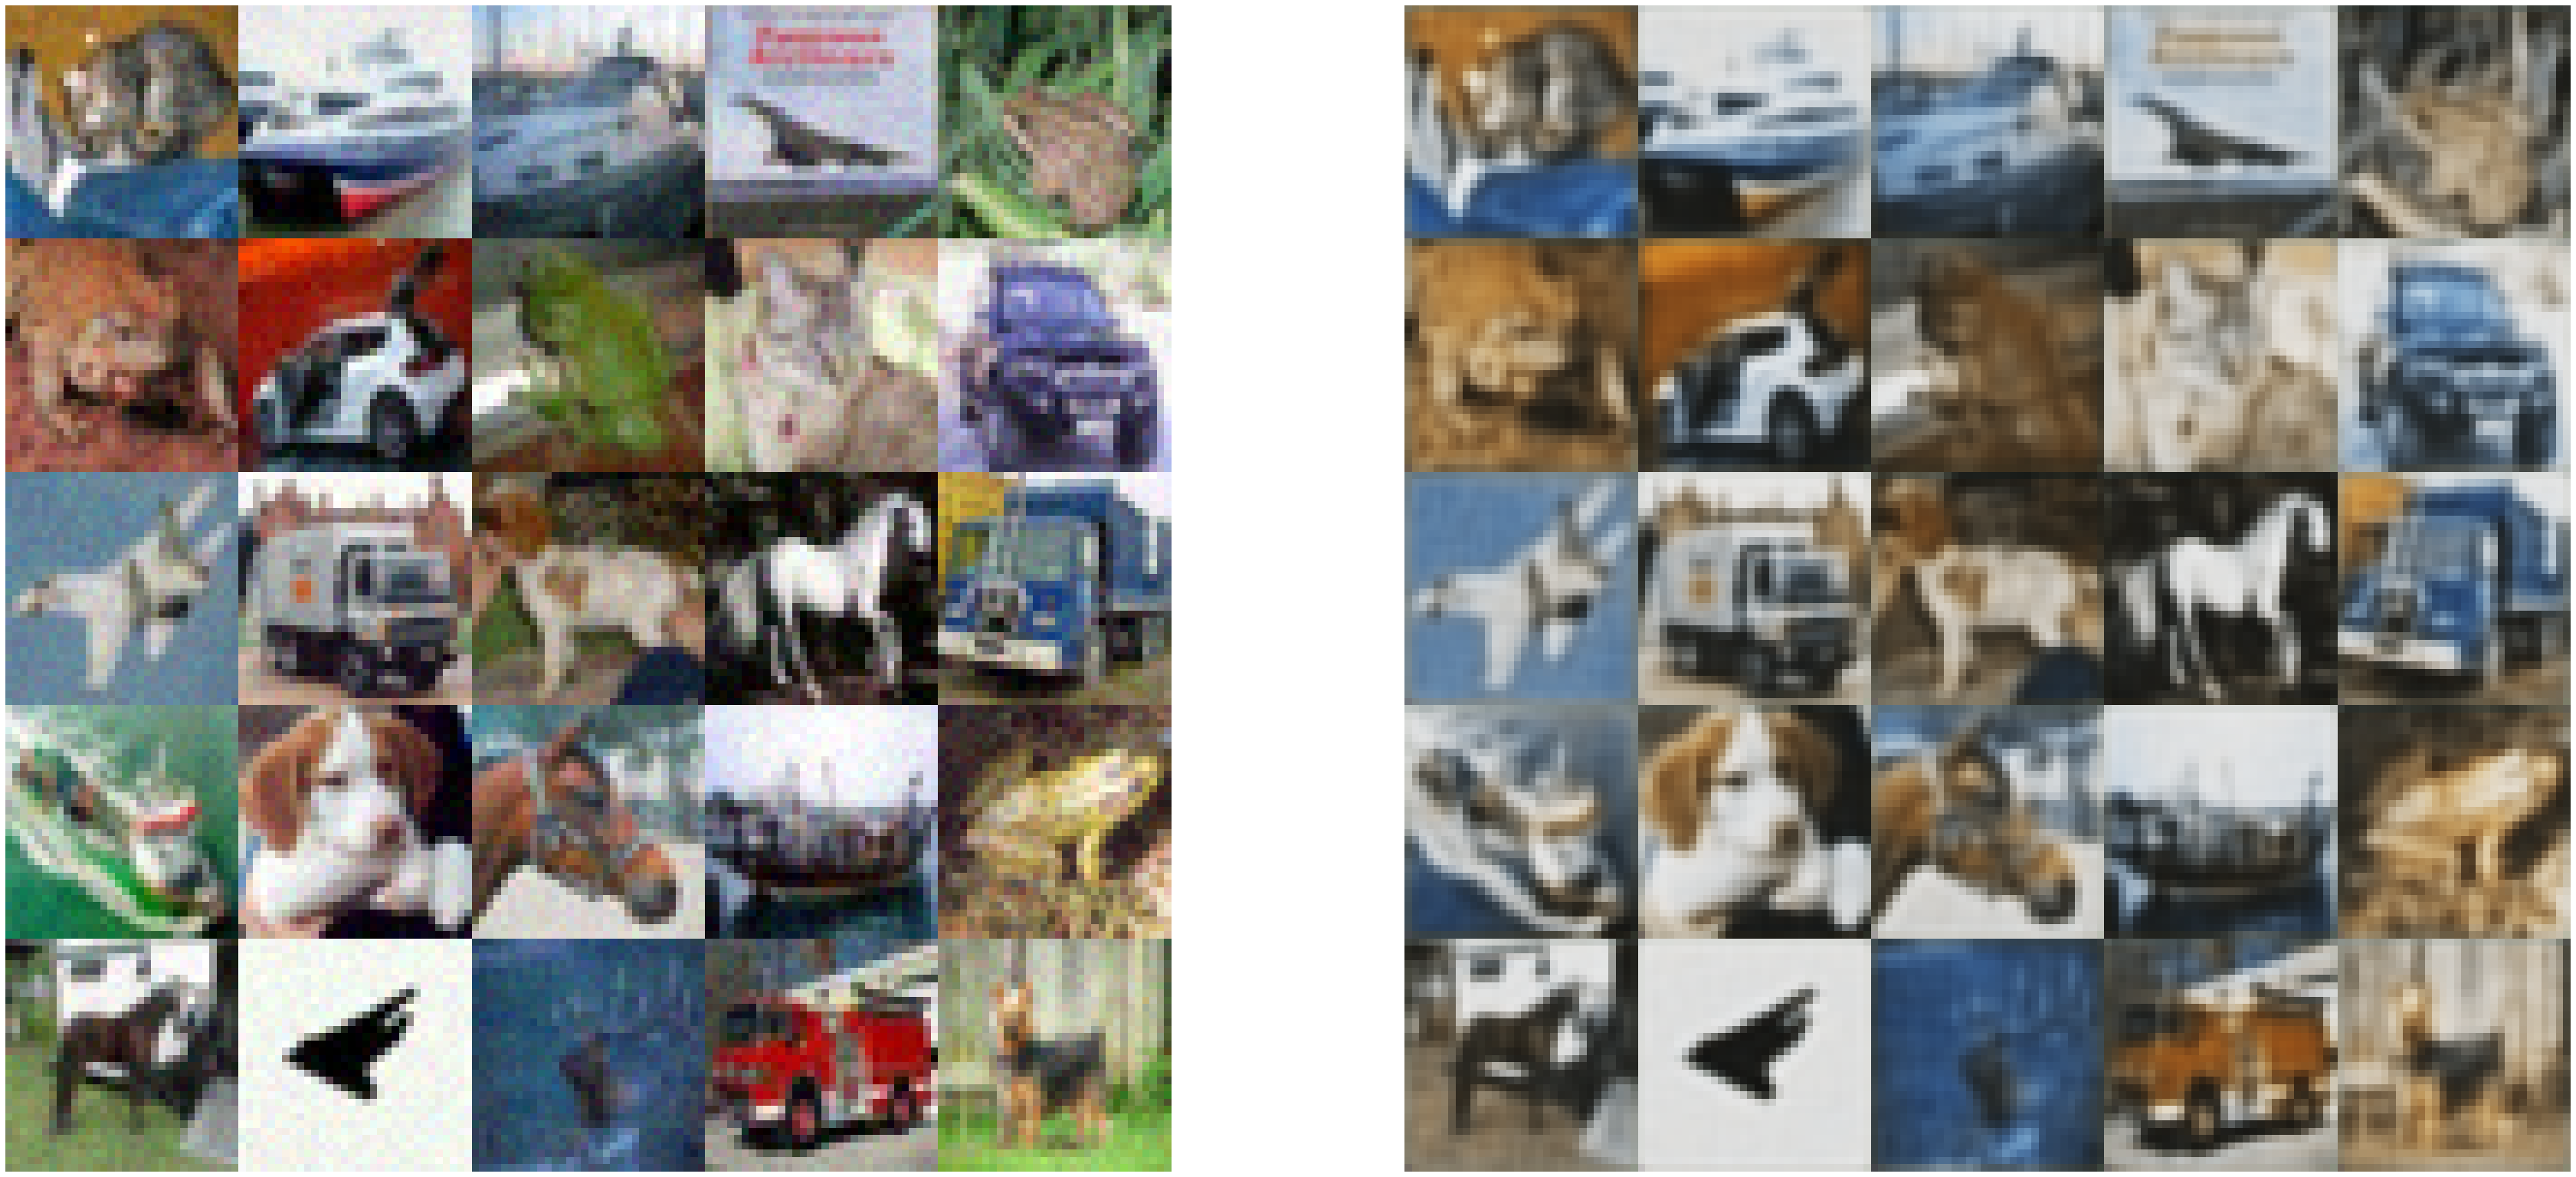

In [ ]:
#x_test = x_test[:400]
NOISE = 0.025
noise = np.random.normal(0, NOISE, x_test.shape)
pred_imgs = model_reformer.predict(x_test + noise)

plt.imshow(sbscompare(x_test + noise, pred_imgs, 5, 5))
plt.axis('off')
plt.rcParams["figure.figsize"] = [60,60]
plt.show()

# MagNet Detector & Reformer

In [ ]:
# We compute reconstructions on normal example to determine the threshold of the detector

reconstructions = model_detector.predict(x_test)
train_loss = tf.keras.losses.mae(reconstructions, x_test)

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.066472


In [ ]:
class DetectorReformer():
  def __init__(self,model,thr):
    self.model = model
    self.thr = thr

  def evaluate(self, X):
    # return false if err above threshold
    reconstruction = self.model.predict(X)
    err = np.mean(tf.keras.losses.mae(reconstruction, X))
    if err < self.thr:
      return reconstruction
    else:
      return X

In [ ]:
n = 10
detect = DetectorReformer(model_detector, threshold)

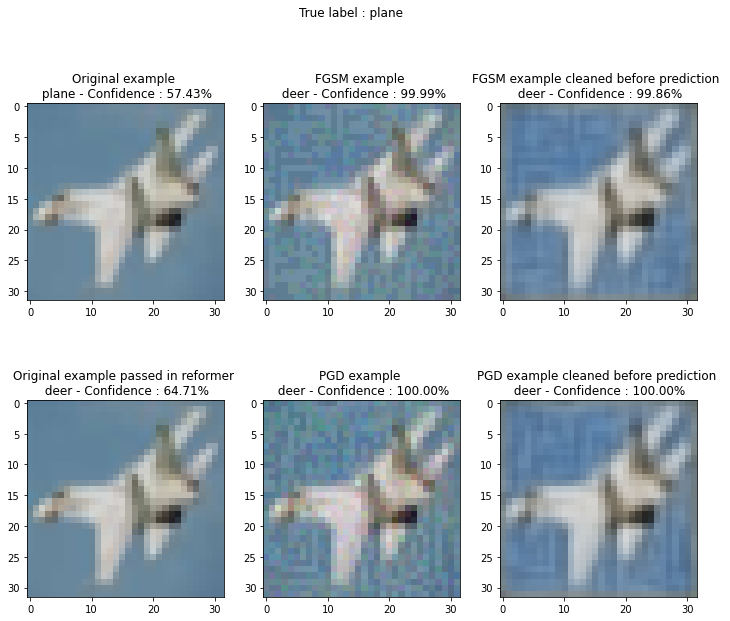

In [ ]:
epsilon = 8/255

alpha = 0.01
nb_iter = 40

plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots(2, 3)

### Classic network (model1)
# True image
#n = np.random.randint(len(x_test)) # Image index to be attacked
#n = 372

label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model1.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]


ax[0,0].imshow(x_test[n])
ax[0,0].set_title('Original example \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))
fig.suptitle('True label : '+label)



# Create FGSM adverserial example

x_pred_adversarial_FGSM = FGSM_adversarial(model1, tf.constant(x_pred), np.reshape(y_test[n],(-1,10)), epsilon)

y_pred_adversarial_FGSM = model1.predict(x_pred_adversarial_FGSM)
confidence_adversarial_FGSM = np.max(y_pred_adversarial_FGSM)
label_pred_adversarial_FGSM = classes[np.argmax(y_pred_adversarial_FGSM)]

x_pred_adversarial_FGSM_plot = np.reshape(x_pred_adversarial_FGSM,(image_shape))
ax[0,1].imshow(x_pred_adversarial_FGSM_plot)
ax[0,1].set_title('FGSM example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))

# Use MagNet
x_cleaned = model_reformer.predict(x_pred_adversarial_FGSM)
y_cleaned = model1.predict(x_cleaned)
confidence_adversarial_FGSM = np.max(y_cleaned)
label_pred_adversarial_FGSM = classes[np.argmax(y_cleaned)]

x_cleaned = np.reshape(x_cleaned,(image_shape))
ax[0,2].imshow(x_cleaned)
ax[0,2].set_title('FGSM example cleaned before prediction \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))

### Classic network (model1)
# True image

label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
x_reformed = model_reformer.predict(x_pred)
y_pred = model1.predict(x_reformed)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]

x_cleaned = np.reshape(x_reformed,(image_shape))
ax[1,0].imshow(x_test[n])
ax[1,0].set_title('Original example passed in reformer \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))



# Create FGSM adverserial example

x_pred_adversarial_FGSM = PGD_adversarial(model1,x_pred, np.reshape(y_test[n],(-1,10)), epsilon, alpha, nb_iter)

y_pred_adversarial_FGSM = model1.predict(x_pred_adversarial_FGSM)
confidence_adversarial_FGSM = np.max(y_pred_adversarial_FGSM)
label_pred_adversarial_FGSM = classes[np.argmax(y_pred_adversarial_FGSM)]

x_pred_adversarial_FGSM_plot = np.reshape(x_pred_adversarial_FGSM,(image_shape))
ax[1,1].imshow(x_pred_adversarial_FGSM_plot)
ax[1,1].set_title('PGD example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))

# Use MagNet
x_cleaned = model_reformer.predict(x_pred_adversarial_FGSM)
y_cleaned = model1.predict(x_cleaned)
confidence_adversarial_FGSM = np.max(y_cleaned)
label_pred_adversarial_FGSM = classes[np.argmax(y_cleaned)]

x_cleaned = np.reshape(x_cleaned,(image_shape))
ax[1,2].imshow(x_cleaned)
ax[1,2].set_title('PGD example cleaned before prediction \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))
fig.savefig("example.png", dpi = 300)


# MagNet Evaluation


In [ ]:
# Attack parameters
sigma = 0.001
n_samples = 40
epsilon = 8/255
alpha = 0.01
nb_iter = 10

In [ ]:
x_adv_test = []
for i in range (len(x_test)):
  x_adv = np.reshape(x_test[i],(1,)+image_shape)
  #x_adv_test.append(PGD_adversarial(model1,x_adv, np.reshape(y_test[i],(-1,10)), epsilon, alpha, nb_iter))
  #x_adv_test.append(FGSM_adversarial(model1,tf.constant(x_adv), np.reshape(y_test[i],(-1,10)), epsilon))
  x_adv_test.append(PGD_blackbox(model1,tf.constant([x_test[n]]), np.reshape(y_test[n],(-1,10)), epsilon, alpha, nb_iter))

In [ ]:
x_adv_test = np.array(x_adv_test).reshape(10000,32,32,3)
noise = np.random.laplace(0, 0.25, x_adv_test.shape)
model1.evaluate(x_adv_test + noise, y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 13.0484 - accuracy: 0.1461


[13.048380851745605, 0.1460999995470047]

In [ ]:
model1.evaluate(model_reformer(x_adv_test), y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 6.4579 - accuracy: 0.1002


[6.45785665512085, 0.10019999742507935]

In [ ]:
model1.evaluate(x_test + noise, y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 17.3041 - accuracy: 0.1275


[17.304061889648438, 0.1274999976158142]

# Adversarial Training

In [ ]:
# Adversarial Model Class
# Subclass Keras model and just modify the train_step function
class FGSM_model(tf.keras.Model):

    def train_step(self, data):
      x,y = data
      with tf.GradientTape() as tape:
        # Classic prediction
        y_pred = self(x)
        # Adversarial precition
        x_adv = FGSM_adversarial(self, x, y,epsilon)
        y_pred_adv = self(x_adv)
        # Loss is the mean of classic loss and adversarial loss
        loss = 0.5*self.compiled_loss(y, y_pred, regularization_losses=self.losses) + 0.5 * self.compiled_loss(y, y_pred_adv, regularization_losses=self.losses)
      
      grads = tape.gradient(loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
      self.compiled_metrics.update_state(y, y_pred)
      return {m.name: m.result() for m in self.metrics}

In [ ]:
# Model trained with adversity
# named model2

input = tf.keras.Input(shape=image_shape)

x = tf.keras.layers.Conv2D(32,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(input)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(64,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(64,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dense(64,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

output = tf.keras.layers.Dense(10,activation = 'softmax')(x)

model2 = FGSM_model(inputs=input, outputs=output)

model2.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics='accuracy')

In [ ]:
# Modify learning rate if needed
K.set_value(model2.optimizer.learning_rate, 0.0001)

In [ ]:
epsilon = 8/255
history = model2.fit(x_train,y_train,epochs=20,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/20
391/391 [==============================] - 21s 49ms/step - loss: 2.2343 - accuracy: 0.2094 - val_loss: 1.9413 - val_accuracy: 0.3197
Epoch 2/20
391/391 [==============================] - 18s 47ms/step - loss: 1.9848 - accuracy: 0.3696 - val_loss: 1.7108 - val_accuracy: 0.4132
Epoch 3/20
391/391 [==============================] - 18s 47ms/step - loss: 1.8796 - accuracy: 0.4254 - val_loss: 1.6112 - val_accuracy: 0.4475
Epoch 4/20
391/391 [==============================] - 18s 47ms/step - loss: 1.8319 - accuracy: 0.4523 - val_loss: 1.5529 - val_accuracy: 0.4654
Epoch 5/20
391/391 [==============================] - 19s 48ms/step - loss: 1.7962 - accuracy: 0.4695 - val_loss: 1.5189 - val_accuracy: 0.4755
Epoch 6/20
391/391 [==============================] - 19s 47ms/step - loss: 1.7708 - accuracy: 0.4851 - val_loss: 1.4809 - val_accuracy: 0.4908
Epoch 7/20
391/391 [==============================] - 18s 47ms/step - loss: 1.7475 - accuracy: 0.4956 - val_loss: 1.4556 - val_accuracy:

In [ ]:
model2.evaluate(x_adv_test, y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.3339 - accuracy: 0.5408


[1.3339084386825562, 0.5407999753952026]

In [ ]:
noise = np.random.normal(0, 0.05, x_adv_test.shape)
model2.evaluate(x_adv_test+noise, y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.3504 - accuracy: 0.5280


[1.350389838218689, 0.527999997138977]

In [ ]:
model2.evaluate(model_reformer(x_adv_test), y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 1.3900 - accuracy: 0.5284


[1.3899608850479126, 0.5284000039100647]

In [ ]:
# Model trained without adversity
# named model1

input = tf.keras.Input(shape=image_shape)

x = tf.keras.layers.Conv2D(32,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(input)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(64,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(64,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.GaussianNoise(0.25)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dense(64,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

output = tf.keras.layers.Dense(10,activation = 'softmax')(x)

model3 = tf.keras.Model(inputs=input, outputs=output)

model3.summary()

model3.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics='accuracy')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 16, 16, 64)        0         
                                                           

In [ ]:
history = model3.fit(x_train,y_train,epochs=20,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/20
391/391 [==============================] - 8s 17ms/step - loss: 1.7335 - accuracy: 0.3755 - val_loss: 1.5548 - val_accuracy: 0.4444
Epoch 2/20
391/391 [==============================] - 6s 16ms/step - loss: 1.3360 - accuracy: 0.5345 - val_loss: 1.2634 - val_accuracy: 0.5702
Epoch 3/20
391/391 [==============================] - 6s 16ms/step - loss: 1.1633 - accuracy: 0.5996 - val_loss: 1.1950 - val_accuracy: 0.5945
Epoch 4/20
391/391 [==============================] - 6s 16ms/step - loss: 1.0587 - accuracy: 0.6388 - val_loss: 1.0864 - val_accuracy: 0.6321
Epoch 5/20
391/391 [==============================] - 6s 15ms/step - loss: 0.9891 - accuracy: 0.6661 - val_loss: 0.9877 - val_accuracy: 0.6700
Epoch 6/20
391/391 [==============================] - 6s 15ms/step - loss: 0.9259 - accuracy: 0.6901 - val_loss: 0.9351 - val_accuracy: 0.6926
Epoch 7/20
391/391 [==============================] - 6s 15ms/step - loss: 0.8696 - accuracy: 0.7109 - val_loss: 0.9356 - val_accuracy: 0.6911

In [ ]:
model3.evaluate(x_adv_test, y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 2.1317 - accuracy: 0.4664


[2.131706953048706, 0.46639999747276306]

# Comparing both model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


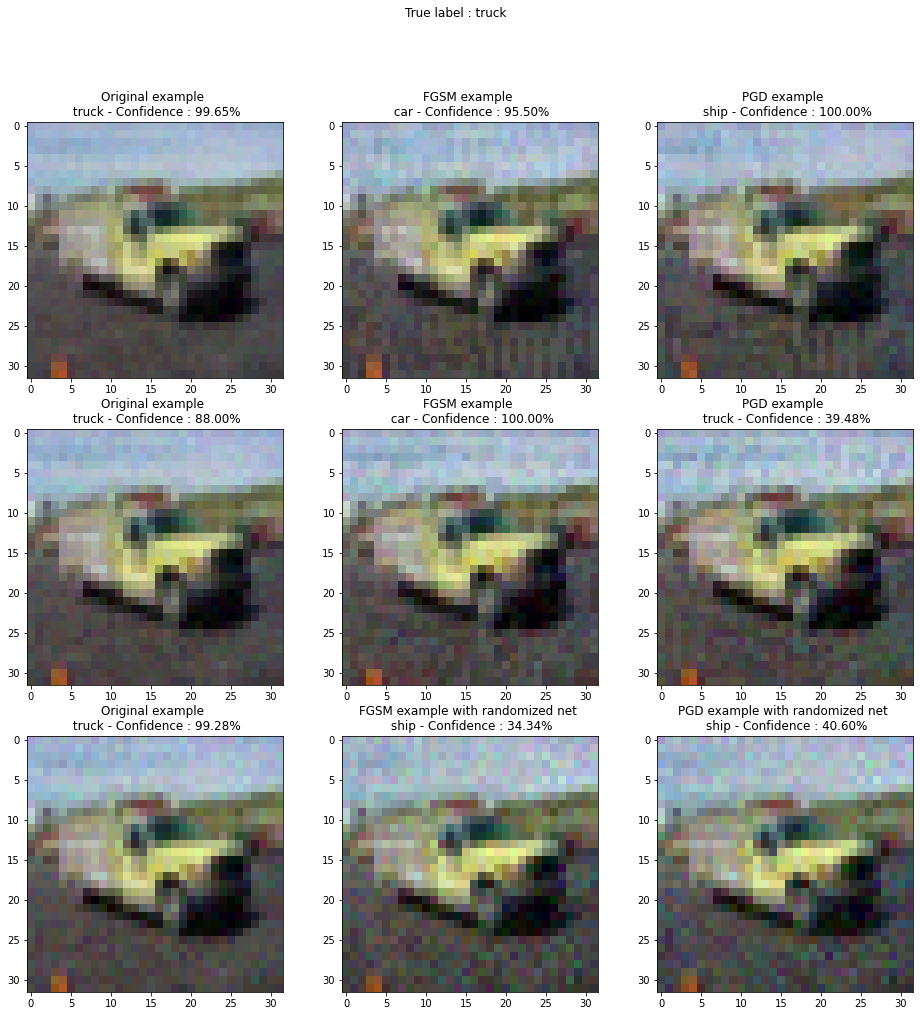

In [ ]:
# Attack parameters
epsilon = 8/255

alpha = 0.01
nb_iter = 40

plt.rcParams['figure.figsize'] = [16, 16]
fig, ax = plt.subplots(3, 3)

### Classic network (model1)
# True image
n = np.random.randint(len(x_test)) # Image index to be attacked

label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model1.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]


ax[0,0].imshow(x_test[n])
ax[0,0].set_title('Original example \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))




# Create FGSM adverserial example

x_pred_adversarial_FGSM = FGSM_adversarial(model1, tf.constant(x_pred), np.reshape(y_test[n],(-1,10)), epsilon)

y_pred_adversarial_FGSM = model1.predict(x_pred_adversarial_FGSM)
confidence_adversarial_FGSM = np.max(y_pred_adversarial_FGSM)
label_pred_adversarial_FGSM = classes[np.argmax(y_pred_adversarial_FGSM)]

x_pred_adversarial_FGSM = np.reshape(x_pred_adversarial_FGSM,(image_shape))
ax[0,1].imshow(x_pred_adversarial_FGSM)
ax[0,1].set_title('FGSM example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))



# Create PGD adverserial example


x_pred_adversarial_PGD = PGD_adversarial(model1,x_pred, np.reshape(y_test[n],(-1,10)), epsilon, alpha, nb_iter)

y_pred_adversarial_PGD = model1.predict(x_pred_adversarial_PGD)
confidence_adversarial_PGD = np.max(y_pred_adversarial_PGD)
label_pred_adversarial_PGD = classes[np.argmax(y_pred_adversarial_PGD)]

x_pred_adversarial_PGD = np.reshape(x_pred_adversarial_PGD,(image_shape))
ax[0,2].imshow(x_pred_adversarial_PGD)
ax[0,2].set_title('PGD example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_PGD,confidence_adversarial_PGD*100))
fig.suptitle('True label : '+label)


### Adversial trained network (model2)

# True image

label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model3.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]


ax[1,0].imshow(x_test[n])
ax[1,0].set_title('Original example \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))

# Create FGSM adverserial example

x_pred_adversarial_FGSM = FGSM_adversarial(model3, tf.constant(x_pred), np.reshape(y_test[n],(-1,10)), epsilon)

y_pred_adversarial_FGSM = model3.predict(x_pred_adversarial_FGSM)
confidence_adversarial_FGSM = np.max(y_pred_adversarial_FGSM)
label_pred_adversarial_FGSM = classes[np.argmax(y_pred_adversarial_FGSM)]

x_pred_adversarial_FGSM = np.reshape(x_pred_adversarial_FGSM,(image_shape))
ax[1,1].imshow(x_pred_adversarial_FGSM)
ax[1,1].set_title('FGSM example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))



# Create PGD adverserial example

x_pred_adversarial_PGD = PGD_adversarial(model3,x_pred, np.reshape(y_test[n],(-1,10)), epsilon, alpha, nb_iter)

y_pred_adversarial_PGD = model2.predict(x_pred_adversarial_PGD)
confidence_adversarial_PGD = np.max(y_pred_adversarial_PGD)
label_pred_adversarial_PGD = classes[np.argmax(y_pred_adversarial_PGD)]

x_pred_adversarial_PGD = np.reshape(x_pred_adversarial_PGD,(image_shape))
ax[1,2].imshow(x_pred_adversarial_PGD)
ax[1,2].set_title('PGD example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_PGD,confidence_adversarial_PGD*100))

# True image


label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
noise = np.random.normal(0, 0.025, size=x_pred.shape)
y_pred = model1.predict(x_pred + noise)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]


ax[2,0].imshow(x_test[n])
ax[2,0].set_title('Original example \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))

# Create FGSM adverserial example under randomized nets

x_pred_adversarial_FGSM = FGSM_adversarial(model2, tf.constant(x_pred), np.reshape(y_test[n],(-1,10)), epsilon)
y_pred_adversarial_FGSM = model2.predict(x_pred_adversarial_FGSM + noise)
confidence_adversarial_FGSM = np.max(y_pred_adversarial_FGSM)
label_pred_adversarial_FGSM = classes[np.argmax(y_pred_adversarial_FGSM)]

x_pred_adversarial_FGSM = np.reshape(x_pred_adversarial_FGSM + noise,(image_shape))
ax[2,1].imshow(x_pred_adversarial_FGSM)
ax[2,1].set_title('FGSM example with randomized net \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_FGSM,confidence_adversarial_FGSM*100))

# Create PGD adverserial example under randomized nets

x_pred_adversarial_PGD = PGD_adversarial(model2,x_pred, np.reshape(y_test[n],(-1,10)), epsilon, alpha, nb_iter)

y_pred_adversarial_PGD = model2.predict(x_pred_adversarial_PGD + noise)
confidence_adversarial_PGD = np.max(y_pred_adversarial_PGD)
label_pred_adversarial_PGD = classes[np.argmax(y_pred_adversarial_PGD)]

x_pred_adversarial_PGD = np.reshape(x_pred_adversarial_PGD + noise,(image_shape))
ax[2,2].imshow(x_pred_adversarial_PGD)
ax[2,2].set_title('PGD example with randomized net \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial_PGD,confidence_adversarial_PGD*100))

plt.savefig('attack_comparison.png',dpi = 300)